In [1]:
from phi.flow import *
from matplotlib import pyplot as plt
import numpy as np
import random

C:\Users\imeho\Desktop\25.01.25\DeepDiffFluid\venv37\lib\site-packages\phi\viz\display.py:78: UserWarning: GUI is disabled because of missing dependencies: No module named 'dash_core_components'. To install all dependencies, run $ pip install phiflow[gui]
  warnings.warn('GUI is disabled because of missing dependencies: %s. To install all dependencies, run $ pip install phiflow[gui]' % import_error)


In [2]:
def load_shapes(shape_dir):
    files = [os.path.join(shape_dir, file) for file in os.listdir(shape_dir) if file.endswith('.npz')]
    npzs = [np.load(file) for file in files]
    arrays = [npz[npz.files[0]][..., 0] for npz in npzs]
    return arrays


def distribute_random_shape(resolution, batch_size, shape_library, margin=1):
    array = np.zeros((batch_size,) + tuple(resolution) + (1,), np.float32)
    for batch in range(batch_size):
        shape = random.choice(shape_library)
        y = random.randint(margin, resolution[0] - margin - shape.shape[0] - 2)
        x = random.randint(margin, resolution[1] - margin - shape.shape[1] - 2)
        array[batch, y:(y + shape.shape[0]), x:(x + shape.shape[1]), 0] = shape
    assert array.dtype == np.float32
    return array

In [3]:
domain = Domain([64, 64])  # 1D Grid resolution and physical size
step_count = 16  # how many solver steps to perform
dt = 1.0  # Time increment per solver step
example_count = 1000
batch_size = 100
data_path = 'shape-transitions'
pretrain_data_path = 'moving-squares'
shape_library = load_shapes('shapes')
for scene in Scene.list(data_path): scene.remove()

for _ in range(example_count // batch_size):
    scene = Scene.create(data_path, count=batch_size, copy_calling_script=False)
    print(scene)
    start = distribute_random_shape(domain.resolution, batch_size, shape_library)
    end__ = distribute_random_shape(domain.resolution, batch_size, shape_library)
    [scene.write_sim_frame([start], ['density'], frame=f) for f in range(step_count)]
    scene.write_sim_frame([end__], ['density'], frame=step_count)

shape-transitions\sim_000000
shape-transitions\sim_000100
shape-transitions\sim_000200
shape-transitions\sim_000300
shape-transitions\sim_000400
shape-transitions\sim_000500
shape-transitions\sim_000600
shape-transitions\sim_000700
shape-transitions\sim_000800
shape-transitions\sim_000900


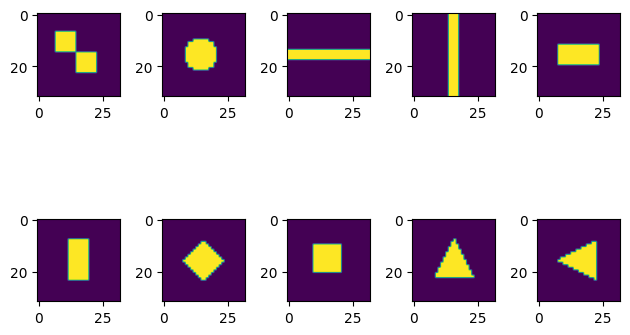

In [4]:
shapes = [np.load(f'shapes/Shape_{i:06d}.npz')['arr_0'] for i in range(10)]

fig, axes = plt.subplots(2, 5)
for i, ax in enumerate(axes.flat):
    ax.imshow(shapes[i])
plt.tight_layout()
plt.show()

In [5]:
for scene in Scene.list(pretrain_data_path): scene.remove()

for scene_index in range(example_count // batch_size):
    scene = Scene.create(pretrain_data_path, count=batch_size, copy_calling_script=False)
    print(scene)
    pos0 = np.random.randint(10, 56, (batch_size, 2))  # start position
    pose = np.random.randint(10, 56, (batch_size, 2))  # end position
    size = np.random.randint(6, 10, (batch_size, 2))
    for frame in range(step_count + 1):
        time = frame / float(step_count + 1)
        pos = np.round(pos0 * (1 - time) + pose * time).astype(np.int)
        density = AABox(lower=pos - size // 2, upper=pos - size // 2 + size).value_at(domain.center_points())
        scene.write_sim_frame([density], ['density'], frame=frame)

moving-squares\sim_000000


C:\Users\imeho\Desktop\25.01.25\DeepDiffFluid\venv37\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


moving-squares\sim_000100
moving-squares\sim_000200
moving-squares\sim_000300
moving-squares\sim_000400
moving-squares\sim_000500
moving-squares\sim_000600
moving-squares\sim_000700
moving-squares\sim_000800
moving-squares\sim_000900


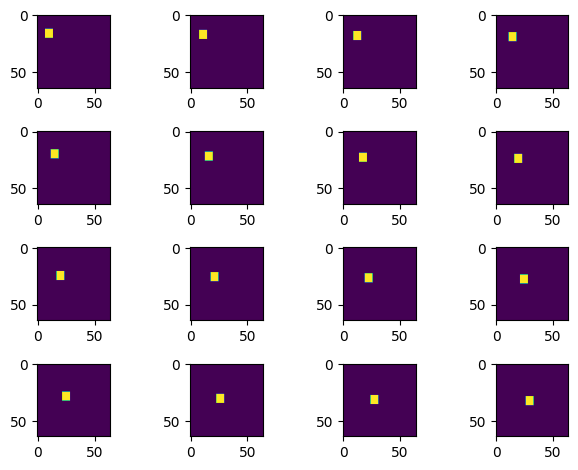

In [6]:
patch = 10
density = [np.load(f'moving-squares/sim_{patch:06d}/density_{j:06d}.npz')['arr_0'] for j in range(17)]

fig, axes = plt.subplots(4, 4)
for i, ax in enumerate(axes.flat):
    ax.imshow(density[i])
plt.tight_layout()
plt.show()

---

In [7]:
test_range = range(100)
val_range = range(100, 200)
train_range = range(200, 1000)
supervised_checkpoints = {}

In [ ]:
from src.control.control_training import ControlTraining
from src.control.pde.incompressible_flow import IncompressibleFluidPDE

for n in [2, 4, 8, 16]:
    app = ControlTraining(n, IncompressibleFluidPDE(domain, dt),
                          datapath=pretrain_data_path, val_range=val_range, train_range=train_range,
                          trace_to_channel=lambda _: 'density',
                          obs_loss_frames=[n // 2], trainable_networks=['OP%d' % n],
                          sequence_class=None).prepare()
    for i in range(1000):
        app.progress()  # Run Optimization for one batch
    supervised_checkpoints['OP%d' % n] = app.save_model()

In [9]:
# supervised_checkpoints = {'OP%d' % n: 'PDE-Control/networks/shapes/supervised/OP%d_1000' % n for n in [2, 4, 8, 16]}

In [ ]:
app = ControlTraining(1, IncompressibleFluidPDE(domain, dt),
                      datapath=pretrain_data_path, val_range=val_range, train_range=train_range,
                      trace_to_channel=lambda _: 'density',
                      obs_loss_frames=[1], trainable_networks=['CFE']).prepare()
for i in range(1000):
    app.progress()  # Run Optimization for one batch
supervised_checkpoints['CFE'] = app.save_model()

In [11]:
# supervised_checkpoints['CFE'] = 'PDE-Control/networks/shapes/CFE/CFE_2000'

In [12]:
from src.control.sequences import StaggeredSequence

staggered_app = ControlTraining(step_count, IncompressibleFluidPDE(domain, dt),
                                datapath=data_path, val_range=val_range, train_range=train_range,
                                trace_to_channel=lambda _: 'density',
                                obs_loss_frames=[step_count], trainable_networks=['CFE', 'OP2', 'OP4', 'OP8', 'OP16'],
                                sequence_class=StaggeredSequence, learning_rate=5e-4).prepare()
staggered_app.load_checkpoints(supervised_checkpoints)
for i in range(1000):
    staggered_app.progress()  # run staggered Optimization for one batch
staggered_checkpoint = staggered_app.save_model()

Optimization (000250): Learning_Rate: 0.0005, GT_obs_16: 6707.341, Loss_reg_unscaled: 2683.2004, Loss_reg_scale: 1.0, Loss: 13414.682 (INFO), 2025-02-27 16:14:51,317n

Validation (000250): Learning_Rate: 0.0005, GT_obs_16: 7632.461, Loss_reg_unscaled: 2847.9285, Loss_reg_scale: 1.0, Loss: 15264.922 (INFO), 2025-02-27 16:14:59,485n

Optimization (000300): Learning_Rate: 0.0005, GT_obs_16: 31578.96, Loss_reg_unscaled: 1642.0562, Loss_reg_scale: 1.0, Loss: 63157.92 (INFO), 2025-02-27 16:29:45,527n

Validation (000300): Learning_Rate: 0.0005, GT_obs_16: 21120.674, Loss_reg_unscaled: 1639.9435, Loss_reg_scale: 1.0, Loss: 42241.348 (INFO), 2025-02-27 16:29:53,845n

Optimization (000350): Learning_Rate: 0.0005, GT_obs_16: 5319.558, Loss_reg_unscaled: 2613.2156, Loss_reg_scale: 1.0, Loss: 10639.116 (INFO), 2025-02-27 16:44:38,274n

Validation (000350): Learning_Rate: 0.0005, GT_obs_16: 3981.7405, Loss_reg_unscaled: 2731.8691, Loss_reg_scale: 1.0, Loss: 7963.481 (INFO), 2025-02-27 16:44:45,988n

In [13]:
# staggered_checkpoint = {net: 'PDE-Control/networks/shapes/staggered/all_53750' for net in ['CFE', 'OP2', 'OP4', 'OP8', 'OP16']}
# staggered_app.load_checkpoints(staggered_checkpoint)

In [14]:
states = staggered_app.infer_all_frames(test_range)

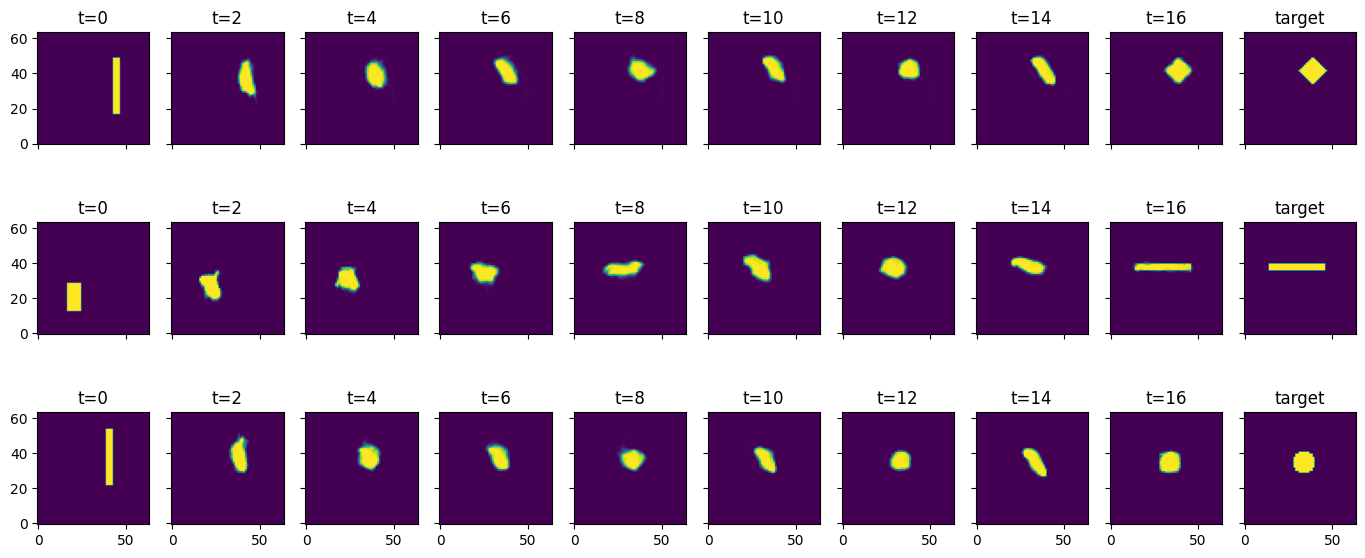

In [15]:
import pylab

batches = [0, 1, 2]

pylab.subplots(len(batches), 10, sharey='row', sharex='col', figsize=(14, 6))
pylab.tight_layout(w_pad=0)

# solutions
for i, batch in enumerate(batches):
    for t in range(9):
        pylab.subplot(len(batches), 10, t + 1 + i * 10)
        pylab.title('t=%d' % (t * 2))
        pylab.imshow(states[t * 2].density.data[batch, ..., 0], origin='lower')

# add targets
testset = BatchReader(Dataset.load(staggered_app.data_path, test_range), staggered_app._channel_struct)[test_range]
for i, batch in enumerate(batches):
    pylab.subplot(len(batches), 10, i * 10 + 10)
    pylab.title('target')
    pylab.imshow(testset[1][i, ..., 0], origin='lower')


In [16]:
errors = []
for batch in enumerate(test_range):
    initial = np.mean( np.abs( states[0].density.data[batch, ..., 0] - testset[1][batch,...,0] ))
    solution = np.mean( np.abs( states[16].density.data[batch, ..., 0] - testset[1][batch,...,0] ))
    errors.append( solution/initial )
print("Relative MAE: "+format(np.mean(errors)))

Relative MAE: 0.05554090440273285
